Loading cervical data into dataframe and analysing the data for any data anomolies which may present. Also fixing the data before applying machine learning algorithis to determine most common cause of cervical cancel among women. 

In [105]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
%matplotlib inline
import math
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.preprocessing import StandardScaler
import imblearn as il
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

Loading the risk factor cervical csv to dataframe

In [106]:
cervical_df=pd.read_csv("/home/centisha/data/Cervical_Cancer/risk_factors_cervical_cancer.csv")

Displaying mean ,max and other stat funtion for preliminary analysis.

In [107]:
cervical_df.describe(include='all')


,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
count,858.000000,858,858,858,858,858,858,858,858,858,...,858,858,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000
unique,NaN,13,22,12,3,31,63,3,41,3,...,19,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,2.0,15.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,?,?,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,272,163,270,722,722,722,481,269,658,...,787,787,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,26.820513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.020979,0.010490,0.020979,0.027972,0.040793,0.086247,0.051282,0.064103
std,8.497948,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.143398,0.101939,0.143398,0.164989,0.197925,0.280892,0.220701,0.245078
min,13.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,25.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,32.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Check if dataset is a balanced set.That means if count of 1's and 0's are close.

In [108]:
cervical_df.groupby('Hinselmann').count()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Number of diagnosis,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Schiller,Citology,Biopsy
Hinselmann,,,,,,,,,,,,,,,,,,,,,
0,823,823,823,823,823,823,823,823,823,823,...,823,823,823,823,823,823,823,823,823,823
1,35,35,35,35,35,35,35,35,35,35,...,35,35,35,35,35,35,35,35,35,35


Checking columns/row with ? as value and then replacing it with null value.

In [109]:
cervical_df.isin(['?']).sum(axis=0)

Age                                     0
Number of sexual partners              26
First sexual intercourse                7
Num of pregnancies                     56
Smokes                                 13
Smokes (years)                         13
Smokes (packs/year)                    13
Hormonal Contraceptives               108
Hormonal Contraceptives (years)       108
IUD                                   117
IUD (years)                           117
STDs                                  105
STDs (number)                         105
STDs:condylomatosis                   105
STDs:cervical condylomatosis          105
STDs:vaginal condylomatosis           105
STDs:vulvo-perineal condylomatosis    105
STDs:syphilis                         105
STDs:pelvic inflammatory disease      105
STDs:genital herpes                   105
STDs:molluscum contagiosum            105
STDs:AIDS                             105
STDs:HIV                              105
STDs:Hepatitis B                  

In [110]:
cervical_df.replace('?', np.nan,inplace=True)

In [111]:
cervical_df.isin(['?']).sum(axis=0)

Age                                   0
Number of sexual partners             0
First sexual intercourse              0
Num of pregnancies                    0
Smokes                                0
Smokes (years)                        0
Smokes (packs/year)                   0
Hormonal Contraceptives               0
Hormonal Contraceptives (years)       0
IUD                                   0
IUD (years)                           0
STDs                                  0
STDs (number)                         0
STDs:condylomatosis                   0
STDs:cervical condylomatosis          0
STDs:vaginal condylomatosis           0
STDs:vulvo-perineal condylomatosis    0
STDs:syphilis                         0
STDs:pelvic inflammatory disease      0
STDs:genital herpes                   0
STDs:molluscum contagiosum            0
STDs:AIDS                             0
STDs:HIV                              0
STDs:Hepatitis B                      0
STDs:HPV                              0


Replacing Null by zero's and one's based on Forward fill and backward fill.

In [112]:
cleanColumns = ["STDs","STDs:condylomatosis","STDs:cervical condylomatosis","STDs:vaginal condylomatosis",
            "STDs:vulvo-perineal condylomatosis","STDs:syphilis","STDs:pelvic inflammatory disease",
            "STDs:genital herpes",
            "STDs:molluscum contagiosum","STDs:AIDS","STDs:HIV","STDs:Hepatitis B","STDs:HPV","Smokes",
            "Hormonal Contraceptives","IUD"]

for column in cleanColumns:
    cervical_df[column] = cervical_df[column].ffill()
    cervical_df[column] = cervical_df[column].bfill()

cervical_df.isin([np.NaN]).sum(axis=0)


Age                                     0
Number of sexual partners              26
First sexual intercourse                7
Num of pregnancies                     56
Smokes                                  0
Smokes (years)                         13
Smokes (packs/year)                    13
Hormonal Contraceptives                 0
Hormonal Contraceptives (years)       108
IUD                                     0
IUD (years)                           117
STDs                                    0
STDs (number)                         105
STDs:condylomatosis                     0
STDs:cervical condylomatosis            0
STDs:vaginal condylomatosis             0
STDs:vulvo-perineal condylomatosis      0
STDs:syphilis                           0
STDs:pelvic inflammatory disease        0
STDs:genital herpes                     0
STDs:molluscum contagiosum              0
STDs:AIDS                               0
STDs:HIV                                0
STDs:Hepatitis B                  

Replacing null values with mean for all the columns with data type as number/float.

In [113]:
float_column=["Smokes (years)","Smokes (packs/year)","Number of sexual partners",
             "First sexual intercourse","Num of pregnancies","Hormonal Contraceptives (years)",
             "IUD (years)","STDs (number)"]
for column in float_column:
    cervical_df[column] = cervical_df[column].astype('float64')

In [114]:
for column in float_column:
    mean=cervical_df[column].mean()
    cervical_df[column]=cervical_df[column].fillna(mean)

In [115]:
cervical_df.isin([np.NaN]).sum(axis=0)

Age                                     0
Number of sexual partners               0
First sexual intercourse                0
Num of pregnancies                      0
Smokes                                  0
Smokes (years)                          0
Smokes (packs/year)                     0
Hormonal Contraceptives                 0
Hormonal Contraceptives (years)         0
IUD                                     0
IUD (years)                             0
STDs                                    0
STDs (number)                           0
STDs:condylomatosis                     0
STDs:cervical condylomatosis            0
STDs:vaginal condylomatosis             0
STDs:vulvo-perineal condylomatosis      0
STDs:syphilis                           0
STDs:pelvic inflammatory disease        0
STDs:genital herpes                     0
STDs:molluscum contagiosum              0
STDs:AIDS                               0
STDs:HIV                                0
STDs:Hepatitis B                  

In [116]:
cervical_df.describe(include='all')

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
count,858.000000,858.000000,858.000000,858.000000,858,858.000000,858.000000,858,858.000000,858,...,71,71,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000
unique,NaN,NaN,NaN,NaN,2,NaN,NaN,2,NaN,2,...,18,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1.0,NaN,0.0,...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,732,NaN,NaN,545,NaN,764,...,15,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,26.820513,2.527644,16.995300,2.275561,NaN,1.219721,0.453144,NaN,2.256419,NaN,...,NaN,NaN,0.020979,0.010490,0.020979,0.027972,0.040793,0.086247,0.051282,0.064103
std,8.497948,1.642267,2.791883,1.399325,NaN,4.057885,2.209657,NaN,3.519082,NaN,...,NaN,NaN,0.143398,0.101939,0.143398,0.164989,0.197925,0.280892,0.220701,0.245078
min,13.000000,1.000000,10.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,NaN,...,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,2.000000,15.000000,1.000000,NaN,0.000000,0.000000,NaN,0.000000,NaN,...,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,25.000000,2.000000,17.000000,2.000000,NaN,0.000000,0.000000,NaN,1.000000,NaN,...,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,32.000000,3.000000,18.000000,3.000000,NaN,0.000000,0.000000,NaN,2.256419,NaN,...,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Column 'STDs: Time since first diagnosis' and 'STDs: Time since last diagnosis' has large number of null. 
Replacing it with mean may not give us correct value of the column

In [117]:
cervical_df['STDs: Time since first diagnosis'].value_counts()

1.0     15
3.0     10
2.0      9
4.0      6
7.0      5
5.0      4
16.0     4
6.0      3
8.0      3
21.0     2
11.0     2
19.0     2
22.0     1
9.0      1
15.0     1
12.0     1
10.0     1
18.0     1
Name: STDs: Time since first diagnosis, dtype: int64

In [118]:
cervical_df['STDs: Time since last diagnosis'].value_counts()

1.0     17
2.0     10
3.0      9
4.0      6
7.0      5
16.0     4
5.0      3
6.0      3
8.0      3
21.0     2
11.0     2
22.0     1
9.0      1
15.0     1
12.0     1
10.0     1
19.0     1
18.0     1
Name: STDs: Time since last diagnosis, dtype: int64

In [119]:
cervical_df.drop(columns=['STDs: Time since first diagnosis', 'STDs: Time since last diagnosis'])

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs:HPV,STDs: Number of diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0000,1.000000,0.0,0.000000,0.00,0.0,0.00,0.0,...,0.0,0,0,0,0,0,0,0,0,0
1,15,1.0,14.0000,1.000000,0.0,0.000000,0.00,0.0,0.00,0.0,...,0.0,0,0,0,0,0,0,0,0,0
2,34,1.0,16.9953,1.000000,0.0,0.000000,0.00,0.0,0.00,0.0,...,0.0,0,0,0,0,0,0,0,0,0
3,52,5.0,16.0000,4.000000,1.0,37.000000,37.00,1.0,3.00,0.0,...,0.0,0,1,0,1,0,0,0,0,0
4,46,3.0,21.0000,4.000000,0.0,0.000000,0.00,1.0,15.00,0.0,...,0.0,0,0,0,0,0,0,0,0,0
5,42,3.0,23.0000,2.000000,0.0,0.000000,0.00,0.0,0.00,0.0,...,0.0,0,0,0,0,0,0,0,0,0
6,51,3.0,17.0000,6.000000,1.0,34.000000,3.40,0.0,0.00,1.0,...,0.0,0,0,0,0,0,1,1,0,1
7,26,1.0,26.0000,3.000000,0.0,0.000000,0.00,1.0,2.00,1.0,...,0.0,0,0,0,0,0,0,0,0,0
8,45,1.0,20.0000,5.000000,0.0,0.000000,0.00,0.0,0.00,0.0,...,0.0,0,1,0,1,1,0,0,0,0
9,44,3.0,15.0000,2.275561,1.0,1.266973,2.80,0.0,0.00,0.0,...,0.0,0,0,0,0,0,0,0,0,0


Droping other three target columns since we are not going to use them for analysis in this project.

In [120]:
cervical_df.drop(columns=['Schiller','Citology','Biopsy'])

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs:Hepatitis B,STDs:HPV,STDs: Number of diagnosis,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann
0,18,4.0,15.0000,1.000000,0.0,0.000000,0.00,0.0,0.00,0.0,...,0.0,0.0,0,NaN,NaN,0,0,0,0,0
1,15,1.0,14.0000,1.000000,0.0,0.000000,0.00,0.0,0.00,0.0,...,0.0,0.0,0,NaN,NaN,0,0,0,0,0
2,34,1.0,16.9953,1.000000,0.0,0.000000,0.00,0.0,0.00,0.0,...,0.0,0.0,0,NaN,NaN,0,0,0,0,0
3,52,5.0,16.0000,4.000000,1.0,37.000000,37.00,1.0,3.00,0.0,...,0.0,0.0,0,NaN,NaN,1,0,1,0,0
4,46,3.0,21.0000,4.000000,0.0,0.000000,0.00,1.0,15.00,0.0,...,0.0,0.0,0,NaN,NaN,0,0,0,0,0
5,42,3.0,23.0000,2.000000,0.0,0.000000,0.00,0.0,0.00,0.0,...,0.0,0.0,0,NaN,NaN,0,0,0,0,0
6,51,3.0,17.0000,6.000000,1.0,34.000000,3.40,0.0,0.00,1.0,...,0.0,0.0,0,NaN,NaN,0,0,0,0,1
7,26,1.0,26.0000,3.000000,0.0,0.000000,0.00,1.0,2.00,1.0,...,0.0,0.0,0,NaN,NaN,0,0,0,0,0
8,45,1.0,20.0000,5.000000,0.0,0.000000,0.00,0.0,0.00,0.0,...,0.0,0.0,0,NaN,NaN,1,0,1,1,0
9,44,3.0,15.0000,2.275561,1.0,1.266973,2.80,0.0,0.00,0.0,...,0.0,0.0,0,NaN,NaN,0,0,0,0,0


Creating scattered matrix to map correlation between columns

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f33c2958110>,
      dtype=object)

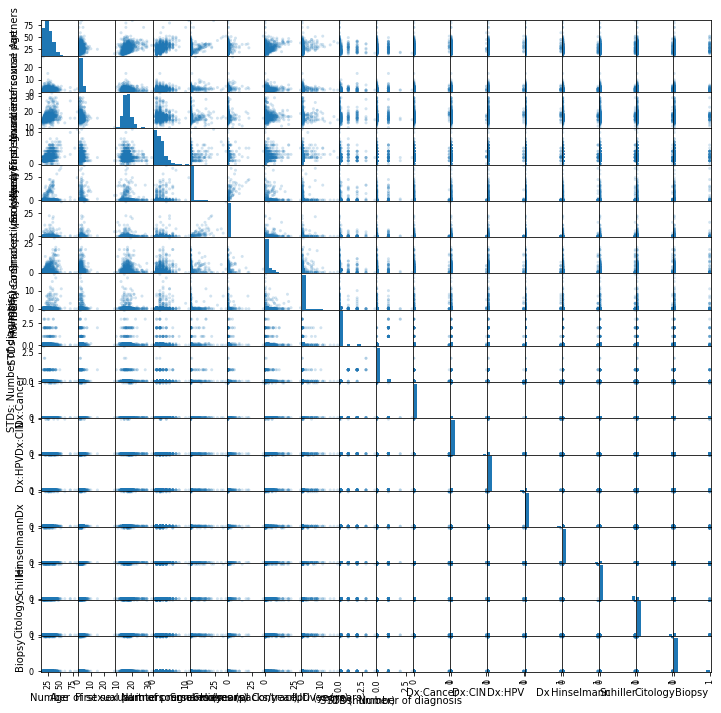

In [121]:
from pandas.plotting import scatter_matrix

scatter_matrix(cervical_df, alpha=0.2,figsize=(12, 12))

Plotting histogram for column Age,Number of sexual partners and First sexual intercourse

plotting graph for age ,number of sexual partners,First sexual intercourse

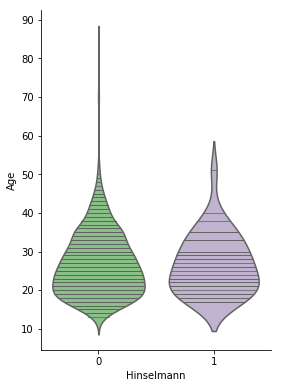

In [122]:
g = sns.PairGrid(cervical_df,
                 y_vars=['Age'],
                 x_vars= ['Hinselmann'],
                 aspect=.75, size=5.5)
g.map(sns.violinplot, palette="Accent",inner='stick');

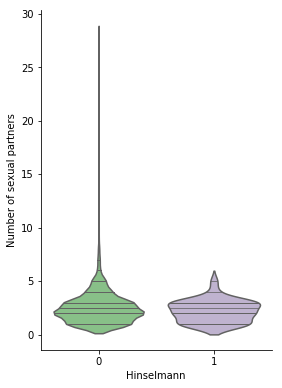

In [123]:
g = sns.PairGrid(cervical_df,
                 y_vars=['Number of sexual partners'],
                 x_vars= ['Hinselmann'],
                 aspect=.75, size=5.5)
g.map(sns.violinplot, palette="Accent",inner='stick');

Vilon plot to compare number of pregnencies between Hinselmann (1,0)

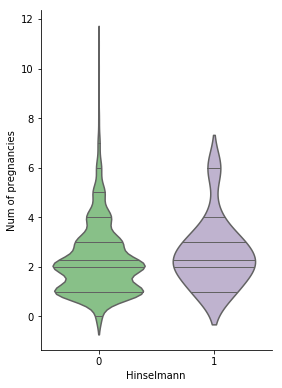

In [125]:
g = sns.PairGrid(cervical_df,
                 y_vars=['Num of pregnancies'],
                 x_vars= ['Hinselmann'],
                 aspect=.75, size=5.5)
g.map(sns.violinplot, palette="Accent",inner='stick');

plotting for smokes years,harmoinal Contraceptives years, IUD (years).

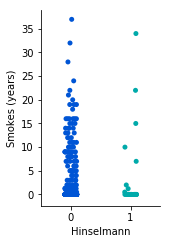

In [126]:
g = sns.PairGrid(cervical_df,
                 y_vars=['Smokes (years)'],
                 x_vars= ['Hinselmann'],
                 aspect=.75, size=3.5)
g.map(sns.stripplot, palette="winter");

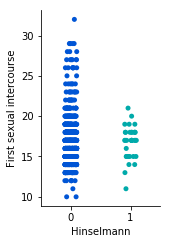

In [127]:
g = sns.PairGrid(cervical_df,
                 y_vars=['First sexual intercourse'],
                 x_vars= ['Hinselmann'],
                 aspect=.75, size=3.5)
g.map(sns.stripplot, palette="winter");

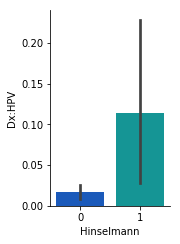

In [128]:
g = sns.PairGrid(cervical_df,
                 y_vars=['Dx:HPV'],
                 x_vars= ['Hinselmann'],
                 aspect=.75, size=3.5)
g.map(sns.barplot, palette="winter");




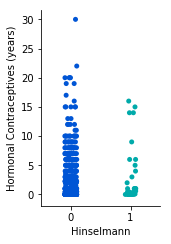

In [129]:
g = sns.PairGrid(cervical_df,
                 y_vars=['Hormonal Contraceptives (years)'],
                 x_vars= ['Hinselmann'],
                 aspect=.75, size=3.5)
g.map(sns.stripplot, palette="winter");

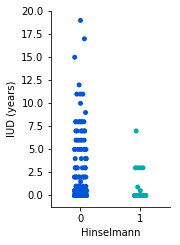

In [130]:
g = sns.PairGrid(cervical_df,
                 y_vars=['IUD (years)'],
                 x_vars= ['Hinselmann'],
                 aspect=.75, size=3.5)
g.map(sns.stripplot, palette="winter");

checking relationship between age-number of sexual partners and age-number of pregnancies

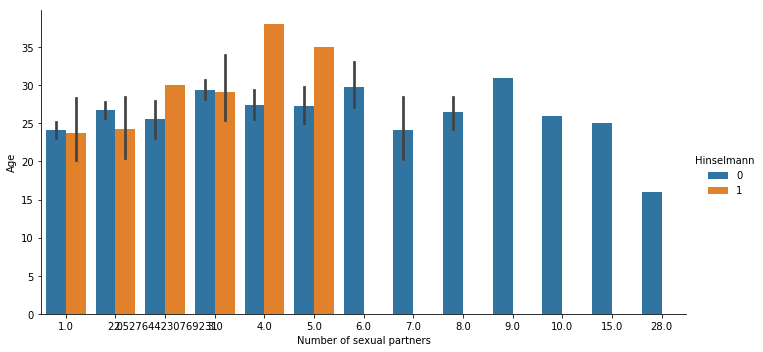

In [131]:

sns.factorplot(x='Number of sexual partners',y='Age',hue='Hinselmann',data=cervical_df,aspect=1.95,kind='bar');


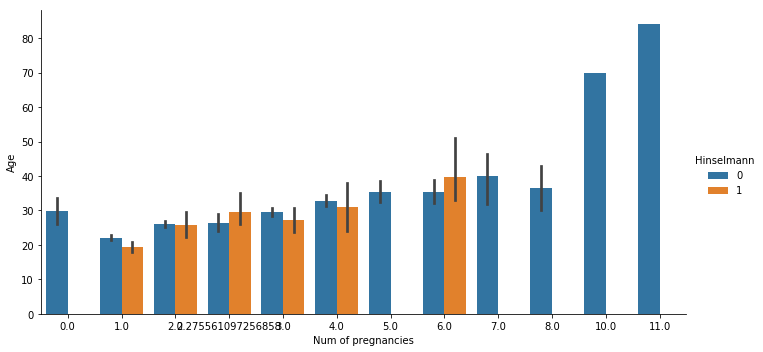

In [86]:
sns.factorplot(x='Num of pregnancies',y='Age',hue='Hinselmann',data=cervical_df,aspect=1.95,kind='bar');

Creating csv for the tranformed data.

In [104]:
cervical_df.to_csv("/home/centisha/data/Cervical_Cancer/risk_factors_cervical_cancer_transformed.csv")